# 018.00 - eigenvalues, eigenvectors, svd and pca - basic example
We will use three methods to obtain our eigenvalues and eigenvectors. Numpy's linear algebra module has a method for obtaining them directly, as well as a method for SVD (singular value decomposition). This method also computes the eigenvalues and eigenvectors, but in addition seperates the original data matrix X into three matrices S, U and V that when combined reconstruct original matrix X. Finally, we will be using the scikit-learn PCA class to do a full principal component analysis and not only find the eigenvalues and eigenvectors but to also apply them to our data to create a new matrix of components scores C that is the transformation of the original data in X into the derived space of orthogonal components. This final matrix C is the end product if we are interested in reducing the dimensionality of our original data. However, we can in theory compute as many components as there are dimensions in our original data. In which case we will have orthogonalized our features (aka the new found components) relative to the original matrix X in which they were likely to be correlated in some way. 

### Import

In [31]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal as mnorm
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression

### Fonts

In [26]:
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Helvetica'}

### Eigenvector definition
image rotating a point around the origin by 45 degrees in a 2 dimensional plane. For this we need a vector v  of 2x1 representing the point we want to rotate and a transformation matrix A of 2x2 specifying the rotation. For our starting point, we take:

$$v = [0,1]$$

<br>
And our transformation matrix implementing the rotation is defined as follows: 

$$A = 
\begin{bmatrix}
cos(\theta) & sin(\theta) \\
-sin(\theta) & cos(\theta) \\
\end{bmatrix}$$

<br> 45 degrees in radians gives us
$$\theta = 45 / 180 * \pi = 0.78539816339 $$

<br>
which yields the following rotation matrix:

$$A = 
\begin{bmatrix}
0.7071 & 0.7071 \\
-0.7071 & 0.7071 \\
\end{bmatrix}$$

### Define the transformation matrix A and vector v

In [300]:
rotation_in_degrees = 45
radians = rotation_in_degrees / 180 * np.pi
A = [[np.cos(radians),np.sin(radians)],[-np.sin(radians),np.cos(radians)]]
A = np.array(A)
v = np.array([0,1])

### Rotate the point

(-1.5, 1.5, -1.5, 1.5)

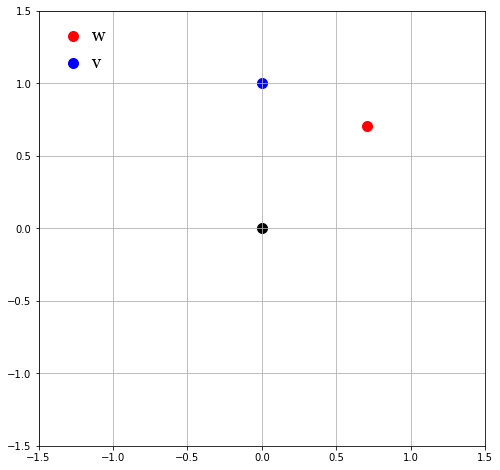

In [326]:
w = np.dot(A,v)
plt.figure(figsize=(8,8))
plt.scatter(w[0],w[1],c='r',s=100,label='w')
plt.scatter(v[0],v[1],c='b',s=100,label='v')
plt.scatter(0,0,c='k',s=100)
plt.grid()
plt.legend(frameon=False,loc='upper left',handletextpad=0,prop={'family':'Georgia', 'size':18})
plt.axis((-1.5,1.5,-1.5,1.5))

### Create an Artificial Dataset
Here, we will generate a very basic data set to demonstrate the basics of PCA. We use the multivariate normal distribution function to generate points drawn from a 2D gaussian distribution with a mean of \[0,0\] and 2x2 covariance matrix sigma where the off diagonal elements are non-zero. Such a non-zero covariance matrix specifying our distribution will rotate the data, introducing a strong correlation between the two dimensions in our data x and y. 

In [386]:
n_samples = 200
resolution = 101
sigma = np.array([[0.75, 0.75], [0.75, 2]])
mu = [0,0]
distr = mnorm(mu,sigma)
X = distr.rvs(n_samples)
xtick = np.linspace(-3,3,7,True)

### Show the contour lines of the probability density function

In [387]:
gridsteps = np.linspace(-8,8,resolution)
xgrid,ygrid = np.meshgrid(gridsteps,gridsteps)
xlist = xgrid.flatten()
ylist = ygrid.flatten()
grid = np.vstack((xlist,ylist)).T
pdf = distr.pdf(grid)
pdf = np.reshape(pdf,((resolution,resolution)))

### Visualize the data
I've used make_regression to create some fake data where y depends on X, thus create an oriented cloud point. This orientation create a dominant axis explaining most of variance observed, while the second axis can only really capture the residual noise observed in the data. In other words, one axis or one dimension suffices to explain this data, allowing us to do dimensionality reduction from 2 -> 1 without loosing much information. Let's use PCA to find that axis and apply the dimensionality reduction to it. 

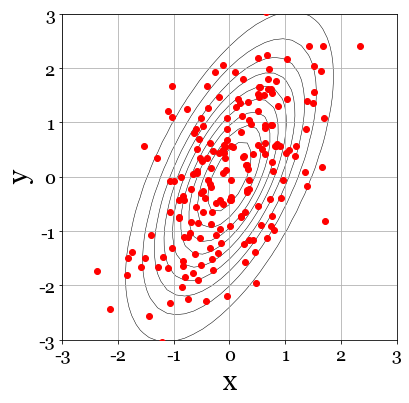

In [388]:
plt.figure(figsize=(6,6))
plt.contour(pdf,extent=(-8,8,-8,8),colors='k',linewidths=0.5,zorder=0,levels=np.linspace(0.0,np.max(pdf),11))
plt.scatter(X[:,0],X[:,1],color=(1,0,0),zorder=100,alpha=1)
plt.grid()
plt.axis((-3,3,-3,3))
plt.xlabel('x',fontsize=28,**csfont);
plt.ylabel('y',fontsize=28,**csfont);
plt.xticks(xtick,labels=xtick.astype(int),fontsize=18,**csfont);
plt.yticks(xtick,labels=xtick.astype(int),fontsize=18,**csfont);

# Method one: Use numpy's eig function
The compute the eigenvalues and eigenvectors using the eig function, we first have to center the matrix at 0 and compute the covariance matrix. It is the covariance matrix the 'eig' function uses to compute the eigenvectors and eigenvalues. in the SVD function, as well as in scikit-learn's PCA function this is done internally. When you look at the eigenvalues, you will notice that the largest value is actually the second entry, meaning that the second eigenvector explains most of the data. Again, the other two algorithms will sort the eigenvectors so that they are in descending order of eigenvalue. This means that later eigenvectors explain less and less variance. Plotting the eigenvalues derived from your data gives you a good sense of what dimensions to keep and which to discard, particularly when the dimensionality of your data is high. Here, we only have two dimensions, so relatively little to work with. Later, we will run PCA on a much larger data set. 

In [389]:
centered_matrix = X.T - X.T.mean(axis=1)[:, np.newaxis]
cov = np.dot(centered_matrix, centered_matrix.T)
eigvals, eigvecs = np.linalg.eig(cov)
eigval1 = eigvals[0] 
eigval2 = eigvals[1]
eigvector1 = eigvecs[:,0]
eigvector2 = eigvecs[:,1]

### Plot the Eigenvectors
The two yellow arrows are the eigenvectors. They are unit length (length=1), so they tell us the direction two orthogonal axis that were computed, but not how much variance each axis explains. This information is captured by the eigenvalues. Scaling the two eigenvectors by the respective eigenvalues creates the orange arrows that clear reveal one of the eigenvectors (2 in this case, because 'eig' doesn't sort our eigenvectors based on eigenvalues) is clearly explaining the majority of the variance observed. Given the domain of our data, it is hard to visualize the eigenvalues with their original value, as they are too large, so I have scaled them a bit for visualization purposes.

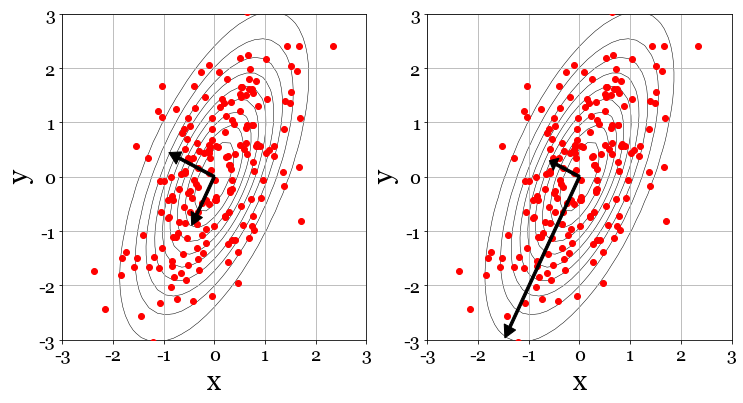

In [403]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.contour(pdf,extent=(-8,8,-8,8),colors='k',linewidths=0.5,zorder=0,levels=np.linspace(0.0,np.max(pdf),11))
plt.scatter(X[:,0],X[:,1],color=(1,0,0),zorder=100,alpha=1)
plt.arrow(0,0,eigvector1[0],eigvector1[1],
          width = 0.05,
          length_includes_head = True,
          head_width = 5*0.05,
          head_length = 1.5*3*0.05,
          head_starts_at_zero = False,
          color = 'k',
          zorder=300)
plt.arrow(0,0,eigvector2[0],eigvector2[1],
          width = 0.05,
          length_includes_head = True,
          head_width = 5*0.05,
          head_length = 1.5*3*0.05,
          head_starts_at_zero = False,
          color = 'k',
          zorder=300)
plt.axis((-3,3,-3,3))
plt.grid()
plt.xlabel('x',fontsize=28,**csfont);
plt.ylabel('y',fontsize=28,**csfont);
plt.xticks(xtick,labels=xtick.astype(int),fontsize=18,**csfont);
plt.yticks(xtick,labels=xtick.astype(int),fontsize=18,**csfont);


plt.subplot(1,2,2)
plt.contour(pdf,extent=(-8,8,-8,8),colors='k',linewidths=0.5,zorder=0,levels=np.linspace(0.0,np.max(pdf),11))
plt.scatter(X[:,0],X[:,1],color=(1,0,0),zorder=100,alpha=1)
plt.arrow(0,0,eigvector1[0]*eigval1*0.008,eigvector1[1]*eigval1*0.008,
          width = 0.05,
          length_includes_head = True,
          head_width = 5*0.05,
          head_length = 1.5*2*0.05,
          head_starts_at_zero = False,
          color = 'k',
          zorder=300)
plt.arrow(0,0,eigvector2[0]*eigval2*0.008,eigvector2[1]*eigval2*0.008,
          width = 0.05,
          length_includes_head = True,
          head_width = 5*0.05,
          head_length = 1.5*3*0.05,
          head_starts_at_zero = False,
          color = 'k',
          zorder=300)
plt.axis((-3,3,-3,3))
plt.grid()
plt.xlabel('x',fontsize=28,**csfont);
plt.ylabel('y',fontsize=28,**csfont);
plt.xticks(xtick,labels=xtick.astype(int),fontsize=18,**csfont);
plt.yticks(xtick,labels=xtick.astype(int),fontsize=18,**csfont);

# Method two: Use numpy's SVD function

Numpys SVD function internally uses the eig function but add some extra useful functionality and processing. For example, the eigenvectors are sorted based on their outputs, and the original matrix X is decomposed into three seperate matrices that when applied in sequence together reconstruct our data set X:

### $$X = U \Sigma V^*$$

We image data our data X in the synthetic example data used in this notebook, or any kind of data to which we want to apply dimensionality reduction is some transformation of the same points whose mean and variance are equal across dimensions, and furthermore show no covariance. In other words, the points are all within a perfectly round unit circle (in the case of 2 dimensions like the data used in this notebook, a perfectly round sphere in the case of 3 dimensions, and a perfectly 'round' hypersphere of n dimensions.

### Run the SVD
After running SVD, we can extract the eigenvectors and eigenvalues from the matrices produced by SVD
The eigenvalues can be obtained from S. However, in SVD, these values in S represent singular values, not eigenvalues. Luckily, they are related by squaring: <br> 

## $$eigen value = singular value^2$$

<br>
in matrix S. Unlike the 'eig' function, these are now sorted based on the amount of variance they explain. The eigenvectors are in V. The final matrix U is the final transformation matrix we need to reproduce our data X had we had started with our data being perfectly homogenous (equal variance and means) and with no covariance. This matrix U is a diagonal matrix transformation matrix, meaning that all off-diagonal values are 0. This, in turn allows U to scale each individual data point by some number, but it can't rotate, translate or shear the points relative to the origin. The rotation is build into the eigenvectors in V, whereas the scaling off each axis is represented by the eigenvalues in S. This entire process is invertable, something build into the PCA method provided by scikit-learn, but also something that is easily implemented here with the SVD matrices produced. The image linked here is a perfect visual of how all these matrices are ultimately linked

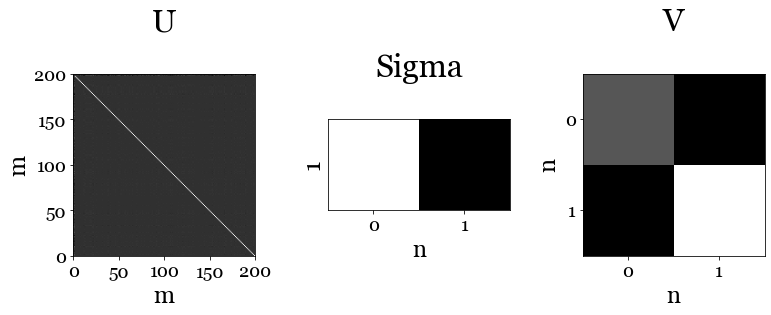

In [409]:
[U,S,V] = np.linalg.svd(X)
svd_eigval1 = S[0]**2
svd_eigval2 = S[1]**2
svd_eigvector1 = V[:,0]
svd_eigvector2 = V[:,1]
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(U,cmap='gray',extent=(0,U.shape[0],0,U.shape[0]));
plt.title('U\n',fontsize=32,**csfont)
plt.xticks(np.linspace(0,U.shape[0],5),fontsize=18,**csfont)
plt.yticks(np.linspace(0,U.shape[0],5),fontsize=18,**csfont)
plt.xlabel('m',fontsize=24,**csfont)
plt.ylabel('m',fontsize=24,**csfont)

plt.subplot(1,3,2)
sigma = np.expand_dims(S,-1)
plt.imshow(sigma.T,cmap='gray')
plt.title('Sigma\n',fontsize=32,**csfont)
plt.yticks([])
plt.xticks([0,1],fontsize=18,**csfont)
plt.ylabel('1',fontsize=24,**csfont)
plt.xlabel('n',fontsize=24,**csfont)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.subplot(1,3,3);
plt.imshow(V,cmap='gray');
plt.title('V\n',fontsize=32,**csfont);
plt.xticks([0,1],fontsize=18,**csfont);
plt.yticks([0,1],fontsize=18,**csfont);
plt.xlabel('n',fontsize=24,**csfont);
plt.ylabel('n',fontsize=24,**csfont);

### Plotting the scaled eigenvectors once more
Combining S with V gives us the result we already obtained before

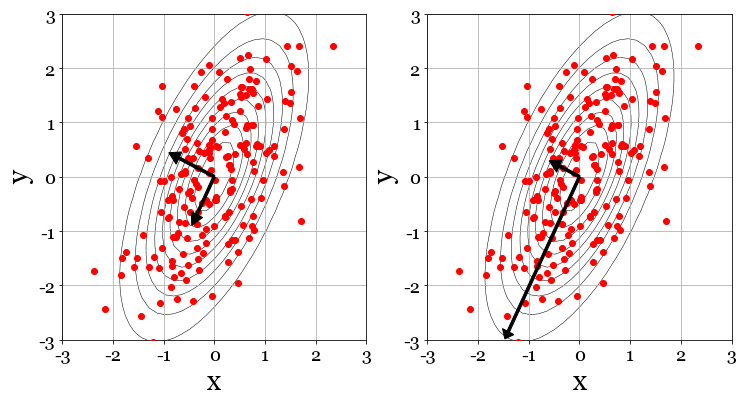

In [411]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.contour(pdf,extent=(-8,8,-8,8),colors='k',linewidths=0.5,zorder=0,levels=np.linspace(0.0,np.max(pdf),11))
plt.scatter(X[:,0],X[:,1],color=(1,0,0),zorder=100,alpha=1)
plt.arrow(0,0,svd_eigvector1[0],svd_eigvector1[1],
          width = 0.05,
          length_includes_head = True,
          head_width = 5*0.05,
          head_length = 1.5*3*0.05,
          head_starts_at_zero = False,
          color = 'k',
          zorder=300)
plt.arrow(0,0,svd_eigvector2[0],svd_eigvector2[1],
          width = 0.05,
          length_includes_head = True,
          head_width = 5*0.05,
          head_length = 1.5*3*0.05,
          head_starts_at_zero = False,
          color = 'k',
          zorder=300)
plt.axis((-3,3,-3,3))
plt.grid()
plt.xlabel('x',fontsize=28,**csfont);
plt.ylabel('y',fontsize=28,**csfont);
plt.xticks(xtick,labels=xtick.astype(int),fontsize=18,**csfont);
plt.yticks(xtick,labels=xtick.astype(int),fontsize=18,**csfont);


plt.subplot(1,2,2)
plt.contour(pdf,extent=(-8,8,-8,8),colors='k',linewidths=0.5,zorder=0,levels=np.linspace(0.0,np.max(pdf),11))
plt.scatter(X[:,0],X[:,1],color=(1,0,0),zorder=100,alpha=1)
plt.arrow(0,0,svd_eigvector1[0]*svd_eigval1*0.008,svd_eigvector1[1]*svd_eigval1*0.008,
          width = 0.05,
          length_includes_head = True,
          head_width = 5*0.05,
          head_length = 1.5*2*0.05,
          head_starts_at_zero = False,
          color = 'k',
          zorder=300)
plt.arrow(0,0,eigvector2[0]*svd_eigval2*0.008,eigvector2[1]*svd_eigval2*0.008,
          width = 0.05,
          length_includes_head = True,
          head_width = 5*0.05,
          head_length = 1.5*3*0.05,
          head_starts_at_zero = False,
          color = 'k',
          zorder=300)
plt.axis((-3,3,-3,3))
plt.grid()
plt.xlabel('x',fontsize=28,**csfont);
plt.ylabel('y',fontsize=28,**csfont);
plt.xticks(xtick,labels=xtick.astype(int),fontsize=18,**csfont);
plt.yticks(xtick,labels=xtick.astype(int),fontsize=18,**csfont);

# PCA
PCA adds one more step to this entire process by constructing a space in which the new dimensions are 1) all orthogonal to each other and 2) the amount of variance explained by each subsequent dimension decreases. This makes it easy for us to decide where to cutoff any additional dimensions. For example, we can use a criteria that we keep only the first n components that together explain at least 95% of the data. For large and correlated data sets, this elimates many dimensions already. After our synthetic data, we can will have a look at a larger synthetic data set that demonstrates this. For now, let's see what PCA (in this case the implementation provided by scikit-learn) has to offer and how it relates to what we already have done

### Scikit-learn PCA
These two lines is all you need to do PCA using scikit learzn

In [412]:
pca = PCA(n_components=2);
C = pca.fit_transform(X);

### Obtained values